In [1]:
import re
import nltk
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction.text import TfidfVectorizer
from google_trans_new import google_translator  
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from wordcloud import WordCloud
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.utils import np_utils
import matplotlib.pyplot as plt
from sklearn import preprocessing
import typing
import numpy as np
import pandas as pd

In [2]:
fg_df = pd.read_csv('D:/Users/ehern/Desktop/Machine Learning/Project/fall_guys_metacritic_reviews.csv')

fg_df.head()

,username,review_type,published_date,score,votes,review_text,profile_url,platform
0,Fen1ma,user,"Aug 26, 2020",6.0,0.0,"на данный момент не советую покупать игру, ещё...",https://www.metacritic.com/user/Fen1ma,pc
1,Locke_VI,user,"Aug 25, 2020",3.0,0.0,Fall Guys was a game I was really looking forw...,https://www.metacritic.com/user/Locke_VI,pc
2,Crisener,user,"Aug 25, 2020",8.0,0.0,You gotta love it. The aesthetics are very col...,https://www.metacritic.com/user/Crisener,pc
3,EnigmaXtreme,user,"Aug 25, 2020",7.0,0.0,When we covered Fall Guys last week during it’...,https://www.metacritic.com/user/EnigmaXtreme,pc
4,nitorita,user,"Aug 23, 2020",7.0,0.0,I like how Fall Guys adapted Mario Party and m...,https://www.metacritic.com/user/nitorita,pc


In [3]:
fg_df.drop(columns=['username','review_type','published_date','published_date', 'votes', 'profile_url', 'platform'],inplace=True)

In [4]:
noNull = fg_df.dropna()

In [5]:
# for i in noNull['review_text']:
#     detector = google_translator()  
#     detect_result = detector.detect(i)
#     print(detect_result)

In [6]:
translations = {}
for i in noNull['review_text']:
    translator = google_translator()
    translations[i] = translator.translate(i, lang_tgt='en')
    
noNull.replace(translations, inplace = True)

# check translation
noNull

C:\Users\ehern\anaconda3\lib\site-packages\pandas\core\frame.py:4166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,score,review_text
0,6.0,At the moment I do not advise you to buy the g...
1,3.0,Fall Guys was a game I was really looking forw...
2,8.0,You gotta love it. The aesthetics are very col...
3,7.0,When we covered Fall Guys last week during it’...
4,7.0,I like how Fall Guys adapted Mario Party and m...
...,...,...
349,1.0,Fall guys is a great game that is destroyed by...
350,9.0,"Simple and fun, very easy to understand gamepl..."
351,8.0,"HIVALLY FOR ALL ages, and when you only have a..."
352,9.0,This game is fun but when you play with friend...


In [7]:
translated_df = noNull.copy()

In [8]:
translated_df.isnull().sum()

score          0
review_text    0
dtype: int64

In [9]:
translated_df.describe()

,score
count,329.000000
mean,6.802432
std,3.340512
min,0.000000
25%,5.000000
50%,8.000000
75%,10.000000
max,10.000000


In [10]:
translated_df['score'].value_counts()

10.0    83
8.0     61
9.0     50
0.0     34
7.0     26
6.0     20
5.0     15
2.0     12
1.0     11
3.0     10
4.0      7
Name: score, dtype: int64

In [11]:
translated_df['score'] = translated_df['score'].astype(int)

In [12]:
def posOrNeg(df):
    if (df <= 5):
        return 0
    else:
        return 1

In [13]:
translated_df['new score'] = translated_df['score'].apply(posOrNeg)

In [14]:
translated_df.head()

,score,review_text,new score
0,6,At the moment I do not advise you to buy the g...,1
1,3,Fall Guys was a game I was really looking forw...,0
2,8,You gotta love it. The aesthetics are very col...,1
3,7,When we covered Fall Guys last week during it’...,1
4,7,I like how Fall Guys adapted Mario Party and m...,1


In [15]:
translated_df['new score'].unique()

array([1, 0], dtype=int64)

In [16]:
def remove_links(text):
    # Remove any hyperlinks that may be in the text starting with http
    import re
    return re.sub(r"http\S+", "", text)

def remove_apostrophes(text):
    text = text.replace("'", "")
    text = text.replace('"', "")
    text = text.replace('`', "")
    return text

In [17]:
translated_df['review_text'] = translated_df['review_text'].str.lower()

In [18]:
translated_df['review_text'] = translated_df['review_text'].str.replace('[^\w\s]','')

In [19]:
translated_df['review_text'] = translated_df['review_text'].astype(str).apply(remove_links)

In [20]:
translated_df['review_text'] = translated_df['review_text'].apply(remove_apostrophes)

In [21]:
translated_df.head()

,score,review_text,new score
0,6,at the moment i do not advise you to buy the g...,1
1,3,fall guys was a game i was really looking forw...,0
2,8,you gotta love it the aesthetics are very colo...,1
3,7,when we covered fall guys last week during its...,1
4,7,i like how fall guys adapted mario party and m...,1


In [22]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction.text import TfidfVectorizer

In [23]:
def tokenize(text):
    tokens = re.split('\W+', str(text))
    return tokens

translated_df['review_text'] = translated_df['review_text'].apply(lambda w: tokenize(w))
translated_df.head()

,score,review_text,new score
0,6,"[at, the, moment, i, do, not, advise, you, to,...",1
1,3,"[fall, guys, was, a, game, i, was, really, loo...",0
2,8,"[you, gotta, love, it, the, aesthetics, are, v...",1
3,7,"[when, we, covered, fall, guys, last, week, du...",1
4,7,"[i, like, how, fall, guys, adapted, mario, par...",1


In [24]:
stopwords = nltk.corpus.stopwords.words('english')
def removeStopWords(text):
    cleanText = [w for w in text if w not in stopwords]
    return cleanText

translated_df['review_text'] = translated_df['review_text'].apply(lambda w: removeStopWords(w))
translated_df.head()

,score,review_text,new score
0,6,"[moment, advise, buy, game, still, raw, br, mi...",1
1,3,"[fall, guys, game, really, looking, forward, f...",0
2,8,"[gotta, love, aesthetics, colorful, charming, ...",1
3,7,"[covered, fall, guys, last, week, beta, talked...",1
4,7,"[like, fall, guys, adapted, mario, party, made...",1


In [25]:
def listToString(text): 
    str1 = " " 
    return (str1.join(text))
        
translated_df['review_text'] = translated_df['review_text'].apply(lambda w: listToString(w))
translated_df.head()

,score,review_text,new score
0,6,moment advise buy game still raw br minuses br...,1
1,3,fall guys game really looking forward first an...,0
2,8,gotta love aesthetics colorful charming gamepl...,1
3,7,covered fall guys last week beta talked fun ga...,1
4,7,like fall guys adapted mario party made suppor...,1


In [26]:
translated_df['review_text'][0]

'moment advise buy game still raw br minuses br absence antichit br cannot change nickname br cursor game hidden 2 times clicking es 1 round br little content br going main menu game may freeze progress game saved br controversial cons support 21 9 maximum permission full hd reduce brightness colors br pros br fun play friends br large selection cart customization br br outcome br worth buying already bought friends cases buy play start adding content '

In [27]:
words = set(nltk.corpus.words.words())

def removeNonEnglish(df):
    return " ".join(w for w in nltk.wordpunct_tokenize(df) \
             if w.lower() in words or not w.isalpha())
    
translated_df['review_text'] = translated_df['review_text'].apply(lambda w: removeNonEnglish(w))
translated_df['review_text'][0]

'moment advise buy game still raw absence cannot change nickname cursor game hidden 2 times es 1 round little content going main menu game may freeze progress game saved controversial support 21 9 maximum permission full reduce brightness colors fun play large selection cart outcome worth already bought buy play start content'

In [28]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sid_analyzer = SentimentIntensityAnalyzer()

In [29]:
def get_sentiment(text:str, desired_type:str='pos'):
    # Get sentiment from text
    sentiment_score = sid_analyzer.polarity_scores(text)
    return sentiment_score[desired_type]

# Get Sentiment scores
def get_sentiment_scores(df,data_column):
    df['positive sentiment score'] = df[data_column].astype(str).apply(lambda x: get_sentiment(x,'pos'))
    df['negative sentiment score'] = df[data_column].astype(str).apply(lambda x: get_sentiment(x,'neg'))
    df['neutral sentiment score'] = df[data_column].astype(str).apply(lambda x: get_sentiment(x,'neu'))
    df['overall sentiment score'] = df[data_column].astype(str).apply(lambda x: (((get_sentiment(x,'pos')) + (get_sentiment(x,'neu'))) - (get_sentiment(x,'neg'))))

    return df

In [30]:
text_sentiment = get_sentiment_scores(translated_df, 'review_text')

display(text_sentiment.sample(5))

,score,review_text,new score,positive sentiment score,negative sentiment score,neutral sentiment score,overall sentiment score
180,9,game good fun bit normal find came recently st...,1,0.299,0.057,0.644,0.886
92,2,buggy randomly stop working tell console port ...,0,0.295,0.238,0.466,0.523
329,9,awesome game would love rate 1010 problem thou...,1,0.290,0.163,0.546,0.673
147,10,game fantasticly fun much future potential ser...,1,0.491,0.000,0.509,1.000
8,8,fall ultimate knockout really fun party game p...,1,0.519,0.133,0.347,0.733


In [31]:
def print_top_n_reviews(df,data_column,number_of_rows):
    for index,row in df.nlargest(number_of_rows,data_column).iterrows():
        print(f"Predicted Score: {row[data_column]}")
        print(f"Review: {row[1]}")
        print(f"Actual Score: {row[2]}\n")

In [32]:
print_top_n_reviews(text_sentiment,'positive sentiment score',2)

Predicted Score: 1.0
Review: better
Actual Score: 1

Predicted Score: 0.938
Review: super fun game entertaining competitive fun
Actual Score: 1



In [33]:
print_top_n_reviews(text_sentiment,'negative sentiment score',2)

Predicted Score: 0.773
Review: stupid football
Actual Score: 0

Predicted Score: 0.697
Review: boring bad music colorful hurt stay away
Actual Score: 0



In [83]:
print_top_n_reviews(text_sentiment,'overall sentiment score',2)

Predicted Score: 1.0
Review: absolutely love game cant put absolutely get skin game perfect
Actual Score: 1

Predicted Score: 1.0
Review: one best use time whether want break relax
Actual Score: 1



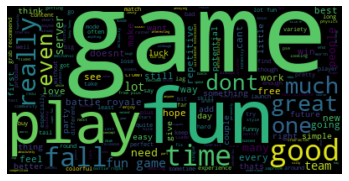

In [35]:
def plot_wordcloud(series,output_filename='wordcloud'):
    wordcloud = WordCloud().generate(' '.join(series.astype(str)))
    wordcloud.to_file(output_filename + '.png')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

plot_wordcloud(translated_df['review_text'],'overall-wordcloud')

def plot_wordcloud_top_n(df,number_of_reviews,score_column,data_column,output_filename):
    sliced_df = df.nlargest(number_of_reviews,score_column)
    plot_wordcloud(sliced_df[data_column],output_filename)

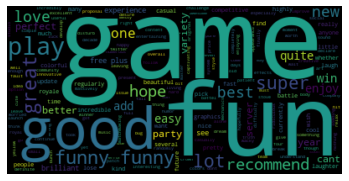

In [36]:
plot_wordcloud_top_n(translated_df,50,'positive sentiment score','review_text','positive-wordcloud')

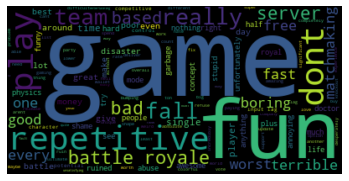

In [37]:
plot_wordcloud_top_n(translated_df,50,'negative sentiment score','review_text','negative-wordcloud')

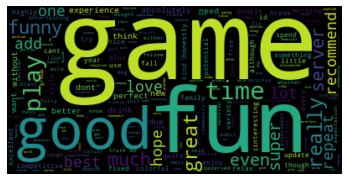

In [82]:
plot_wordcloud_top_n(translated_df,50,'overall sentiment score', 'review_text', 'overall-wordcloud')

In [39]:
features = ['overall sentiment score']
X = translated_df[features]
# lab_enc = preprocessing.LabelEncoder()
y = translated_df['new score']

In [40]:
X

,overall sentiment score
0,0.945
1,0.629
2,0.900
3,0.797
4,0.878
...,...
349,0.592
350,1.000
351,1.000
352,0.887


In [41]:
y

0      1
1      0
2      1
3      1
4      1
      ..
349    0
350    1
351    1
352    1
353    1
Name: new score, Length: 329, dtype: int64

In [42]:
def get_score(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_predict)
    print(classification_report(y_test, y_predict, zero_division=1))
    return accuracy

# Train-Test-Split

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

# KNN

In [44]:
knn = KNeighborsClassifier(n_neighbors=5)

print("Train-test-split Accuracy:", (get_score(knn, X_train, X_test, y_train, y_test))*100)

cv_score_dt = cross_val_score(knn, X, y, cv=5)

print("\nCross Validation Accuracy:", (cv_score_dt.mean())*100)

              precision    recall  f1-score   support

           0       0.44      0.40      0.42        20
           1       0.82      0.84      0.83        63

    accuracy                           0.73        83
   macro avg       0.63      0.62      0.62        83
weighted avg       0.73      0.73      0.73        83

Train-test-split Accuracy: 73.49397590361446

Cross Validation Accuracy: 65.63170163170165


In [45]:
y_predict_prob_knn = knn.predict_proba(X_test)

print(y_predict_prob_knn[:,1])

[0.6 0.8 0.8 0.2 0.6 0.4 0.8 0.8 1.  0.8 0.8 0.8 0.8 0.8 1.  0.6 0.8 1.
 0.2 0.6 1.  0.8 1.  0.8 0.8 0.8 0.2 0.2 0.8 0.4 0.2 0.8 1.  0.8 0.8 1.
 0.8 0.4 0.8 1.  0.8 0.4 0.4 1.  0.6 0.8 0.4 1.  0.6 0.8 1.  1.  0.6 0.6
 0.8 1.  0.8 0.8 0.2 0.6 0.4 0.2 0.6 0.8 0.6 0.6 0.2 0.8 0.8 0.4 0.8 0.6
 0.4 0.8 0.8 0.2 1.  0.8 0.8 0.8 1.  0.8 0.8]


#### FPR and TPR

In [46]:
fpr_knn, tpr_knn, thresholds = metrics.roc_curve(y_test, y_predict_prob_knn[:,1], pos_label=1)

print(fpr_knn)
print("\n")
print(tpr_knn)

[0.   0.05 0.4  0.6  0.85 1.  ]


[0.         0.22222222 0.6984127  0.84126984 0.9047619  1.        ]


#### AUC

In [47]:
AUC_knn = metrics.auc(fpr_knn, tpr_knn)
print(AUC_knn)

0.6817460317460318


# Decision Tree

In [48]:
dt = DecisionTreeClassifier()

print("Train-test-split Accuracy:", (get_score(dt, X_train, X_test, y_train, y_test))*100)

cv_score_dt = cross_val_score(dt, X, y, cv=5)

print("\nCross Validation Accuracy:", (cv_score_dt.mean())*100)

              precision    recall  f1-score   support

           0       0.38      0.40      0.39        20
           1       0.81      0.79      0.80        63

    accuracy                           0.70        83
   macro avg       0.59      0.60      0.60        83
weighted avg       0.70      0.70      0.70        83

Train-test-split Accuracy: 69.87951807228916

Cross Validation Accuracy: 70.2051282051282


In [49]:
y_predict_prob_dt = dt.predict_proba(X_test)

print(y_predict_prob_dt[:,1])

[1.         0.85714286 0.85714286 1.         1.         1.
 1.         1.         1.         0.85714286 0.85714286 0.85714286
 1.         0.85714286 1.         1.         0.85714286 1.
 0.         1.         1.         0.85714286 1.         1.
 1.         0.85714286 0.         0.         0.         0.
 0.         0.85714286 1.         1.         0.85714286 1.
 0.85714286 1.         0.85714286 1.         0.         0.
 0.5        1.         0.5        1.         1.         1.
 0.5        0.5        1.         1.         1.         0.5
 1.         1.         0.85714286 0.85714286 0.         1.
 0.         0.         0.66666667 0.85714286 0.         0.
 0.         0.85714286 0.85714286 0.         0.85714286 1.
 1.         0.85714286 0.5        1.         1.         0.85714286
 1.         0.85714286 1.         0.85714286 0.85714286]


#### FPR and TPR

In [50]:
fpr_dt, tpr_dt, thresholds = metrics.roc_curve(y_test, y_predict_prob_dt[:,1], pos_label=1)

print(fpr_dt)
print("\n")
print(tpr_dt)

[0.   0.4  0.6  0.6  0.75 1.  ]


[0.         0.46031746 0.77777778 0.79365079 0.84126984 1.        ]


#### AUC

In [51]:
AUC_dt = metrics.auc(fpr_dt, tpr_dt)
print(AUC_dt)

0.5686507936507936


# Logistic Regression

In [52]:
lr = LogisticRegression(max_iter=1000)

print("Train-test-split Accuracy:", (get_score(lr, X_train, X_test, y_train, y_test))*100)

cv_score_lr = cross_val_score(lr, X, y, cv=5)

print("\nCross Validation Accuracy:", (cv_score_lr.mean())*100)

              precision    recall  f1-score   support

           0       0.44      0.20      0.28        20
           1       0.78      0.92      0.85        63

    accuracy                           0.75        83
   macro avg       0.61      0.56      0.56        83
weighted avg       0.70      0.75      0.71        83

Train-test-split Accuracy: 74.69879518072288

Cross Validation Accuracy: 75.06759906759906


In [53]:
y_predict_prob_lr = lr.predict_proba(X_test)

print(y_predict_prob_lr[:,1])

[0.73455717 0.84163789 0.84163789 0.39828289 0.68574971 0.76909461
 0.79826596 0.7970019  0.78181876 0.84163789 0.84163789 0.84163789
 0.65755421 0.84163789 0.7190101  0.66863354 0.84163789 0.75441211
 0.35900398 0.66689616 0.79145619 0.84163789 0.70509651 0.59661365
 0.79573195 0.84163789 0.53123808 0.77461056 0.68349523 0.52343047
 0.34353962 0.84163789 0.74560293 0.65696617 0.84163789 0.74560293
 0.84163789 0.30358436 0.84163789 0.75730237 0.79952413 0.72943629
 0.55455427 0.78447862 0.55970684 0.59535655 0.58144927 0.73961572
 0.57380703 0.75003339 0.71848241 0.81297615 0.6492783  0.5571321
 0.69688977 0.70726302 0.84163789 0.84163789 0.33884556 0.64390987
 0.24311023 0.34471797 0.76395595 0.84163789 0.7782356  0.67725101
 0.6066235  0.84163789 0.84163789 0.7648961  0.84163789 0.6016292
 0.30913139 0.84163789 0.75149873 0.47843183 0.70618093 0.84163789
 0.65755421 0.84163789 0.7406199  0.84163789 0.84163789]


#### FPR and TPR

In [54]:
fpr_lr, tpr_lr, thresholds = metrics.roc_curve(y_test, y_predict_prob_lr[:,1], pos_label=1)

print(fpr_lr)
print("\n")
print(tpr_lr)

[0.   0.2  0.2  0.25 0.25 0.3  0.3  0.35 0.35 0.35 0.35 0.4  0.4  0.45
 0.45 0.5  0.5  0.55 0.55 0.6  0.6  0.75 0.75 0.8  0.8  0.85 0.85 0.95
 0.95 1.   1.  ]


[0.         0.31746032 0.38095238 0.38095238 0.47619048 0.47619048
 0.50793651 0.50793651 0.53968254 0.57142857 0.71428571 0.71428571
 0.76190476 0.76190476 0.77777778 0.77777778 0.82539683 0.82539683
 0.88888889 0.88888889 0.9047619  0.9047619  0.92063492 0.92063492
 0.95238095 0.95238095 0.96825397 0.96825397 0.98412698 0.98412698
 1.        ]


#### AUC

In [55]:
AUC_lr = metrics.auc(fpr_lr, tpr_lr)
print(AUC_lr)

0.6738095238095237


# Random Forest

In [56]:
rf = RandomForestClassifier()

print("Train-test-split Accuracy:", (get_score(rf, X_train, X_test, y_train, y_test))*100)

cv_score_rf = cross_val_score(rf, X, y, cv=5)

print("\nCross Validation Accuracy:", (cv_score_rf.mean())*100)

              precision    recall  f1-score   support

           0       0.28      0.25      0.26        20
           1       0.77      0.79      0.78        63

    accuracy                           0.66        83
   macro avg       0.52      0.52      0.52        83
weighted avg       0.65      0.66      0.66        83

Train-test-split Accuracy: 66.26506024096386

Cross Validation Accuracy: 72.02331002331002


In [57]:
y_predict_prob_rf = rf.predict_proba(X_test)

print(y_predict_prob_rf[:,1])

[0.62       0.85544427 0.85544427 0.71       0.72       0.848
 0.995      0.995      1.         0.85544427 0.85544427 0.85544427
 0.99       0.85544427 1.         0.81       0.85544427 1.
 0.02       0.8        1.         0.85544427 1.         0.97
 1.         0.85544427 0.23       0.04       0.43       0.07
 0.01       0.85544427 0.99666667 0.95       0.85544427 0.99666667
 0.85544427 0.71       0.85544427 1.         0.375      0.25
 0.569      1.         0.579      0.94       0.7        1.
 0.45683333 0.4985     1.         1.         0.9        0.579
 0.99       1.         0.85544427 0.85544427 0.08       0.74
 0.3        0.01       0.60513095 0.85544427 0.3        0.18
 0.         0.85544427 0.85544427 0.073      0.85544427 0.69
 0.71       0.85544427 0.4985     0.62       1.         0.85544427
 0.99       0.85544427 1.         0.85544427 0.85544427]


#### FPR and TPR

In [58]:
fpr_rf, tpr_rf, thresholds = metrics.roc_curve(y_test, y_predict_prob_rf[:,1], pos_label=1)

print(fpr_rf)
print("\n")
print(tpr_rf)

[0.   0.1  0.1  0.2  0.2  0.4  0.4  0.45 0.45 0.5  0.5  0.55 0.6  0.6
 0.6  0.6  0.7  0.75 0.75 0.75 0.75 0.75 0.9  0.9  0.95 1.   1.  ]


[0.         0.19047619 0.25396825 0.26984127 0.33333333 0.65079365
 0.66666667 0.66666667 0.68253968 0.68253968 0.6984127  0.73015873
 0.73015873 0.74603175 0.77777778 0.79365079 0.79365079 0.79365079
 0.82539683 0.87301587 0.9047619  0.95238095 0.95238095 0.96825397
 0.96825397 0.98412698 1.        ]


#### AUC

In [59]:
AUC_rf = metrics.auc(fpr_rf, tpr_rf)
print(AUC_rf)

0.6329365079365079


# SVM

In [60]:
svm1 = svm.SVC(probability=True)

print("Train-test-split Accuracy:", (get_score(svm1, X_train, X_test, y_train, y_test))*100)

cv_score_svm = cross_val_score(svm1, X, y, cv=5)

print("\nCross Validation Accuracy:", (cv_score_svm.mean())*100)

              precision    recall  f1-score   support

           0       0.57      0.40      0.47        20
           1       0.83      0.90      0.86        63

    accuracy                           0.78        83
   macro avg       0.70      0.65      0.67        83
weighted avg       0.76      0.78      0.77        83

Train-test-split Accuracy: 78.3132530120482

Cross Validation Accuracy: 76.28438228438229


In [61]:
y_predict_prob_svm = svm1.predict_proba(X_test)

print(y_predict_prob_svm[:,1])

[0.78994284 0.7863109  0.7863109  0.23973263 0.79103586 0.7855892
 0.78931826 0.78907187 0.78649703 0.7863109  0.7863109  0.7863109
 0.77066901 0.7863109  0.79291065 0.78137226 0.7863109  0.78642428
 0.25075701 0.77994378 0.78801696 0.7863109  0.7941245  0.63519515
 0.78882517 0.7863109  0.39627689 0.78580194 0.79018493 0.37323824
 0.25677944 0.7863109  0.78776143 0.76999134 0.7863109  0.78776143
 0.7863109  0.2738371  0.7863109  0.78610755 0.78956306 0.79100146
 0.47673597 0.78685912 0.5        0.63060544 0.57885179 0.78890358
 0.54984241 0.78702591 0.79299087 0.7917736  0.76004819 0.48637891
 0.7936477  0.79408184 0.7863109  0.7863109  0.25869773 0.75186403
 0.30003562 0.25630334 0.78565458 0.7863109  0.78609578 0.78718988
 0.66461839 0.7863109  0.7863109  0.78562363 0.7863109  0.64897601
 0.27139413 0.7863109  0.78680938 0.27658516 0.7941111  0.7863109
 0.77066901 0.7863109  0.78870321 0.7863109  0.7863109 ]


#### FPR and TPR

In [62]:
fpr_svm, tpr_svm, thresholds = metrics.roc_curve(y_test, y_predict_prob_svm[:,1], pos_label=1)

print(fpr_svm)
print("\n")
print(tpr_svm)

[0.   0.   0.   0.05 0.05 0.1  0.1  0.15 0.35 0.35 0.4  0.4  0.45 0.45
 0.5  0.5  0.55 0.55 0.6  0.6  0.75 0.75 0.8  0.8  0.85 0.85 0.95 0.95
 1.   1.  ]


[0.         0.01587302 0.04761905 0.04761905 0.22222222 0.22222222
 0.36507937 0.36507937 0.68253968 0.74603175 0.74603175 0.76190476
 0.76190476 0.79365079 0.79365079 0.82539683 0.82539683 0.88888889
 0.88888889 0.9047619  0.9047619  0.92063492 0.92063492 0.95238095
 0.95238095 0.96825397 0.96825397 0.98412698 0.98412698 1.        ]


#### AUC

In [89]:
AUC_svm = metrics.auc(fpr_svm, tpr_svm)
print(AUC_svm)

0.7126984126984127


In [90]:
clf = MLPClassifier(hidden_layer_sizes = (30,), random_state=1, learning_rate_init = 0.02, solver='adam',
                alpha=1, verbose=True, activation='logistic')

cv_accuracy = cross_val_score(clf, X, y, cv = 5, scoring = 'accuracy', verbose = True)

Iteration 1, loss = 0.64464978
Iteration 2, loss = 0.59385306
Iteration 3, loss = 0.59647162
Iteration 4, loss = 0.59526304
Iteration 5, loss = 0.58807365
Iteration 6, loss = 0.58635387
Iteration 7, loss = 0.58739151
Iteration 8, loss = 0.58766323
Iteration 9, loss = 0.58568462
Iteration 10, loss = 0.58396196
Iteration 11, loss = 0.58320513
Iteration 12, loss = 0.58374624
Iteration 13, loss = 0.58462940
Iteration 14, loss = 0.58532404
Iteration 15, loss = 0.58430682
Iteration 16, loss = 0.58322515
Iteration 17, loss = 0.58423928
Iteration 18, loss = 0.58331252
Iteration 19, loss = 0.58287140
Iteration 20, loss = 0.58341774
Iteration 21, loss = 0.58474526
Iteration 22, loss = 0.58545312
Iteration 23, loss = 0.58397747
Iteration 24, loss = 0.58279291
Iteration 25, loss = 0.58366490
Iteration 26, loss = 0.58696785
Iteration 27, loss = 0.58701864
Iteration 28, loss = 0.58363193
Iteration 29, loss = 0.58296390
Iteration 30, loss = 0.58303561
Training loss did not improve more than tol=0.000

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


In [91]:
ann_accuracy = cv_accuracy.mean()

print("Accuracy", ann_accuracy)

Accuracy 0.7295104895104896


In [92]:
neurons = [(x,) for x in range(5, 353, 5)]

param_grid = dict(hidden_layer_sizes = neurons)

clf_1 = MLPClassifier(random_state=1, learning_rate_init = 0.02, solver='adam',
                alpha=1, verbose=True, activation='logistic')

grid = GridSearchCV(clf_1, param_grid, scoring = 'roc_auc', cv = 5)

grid_result = grid.fit(X, y)

Iteration 1, loss = 0.67289950
Iteration 2, loss = 0.64615773
Iteration 3, loss = 0.62582584
Iteration 4, loss = 0.60971047
Iteration 5, loss = 0.59855970
Iteration 6, loss = 0.59133814
Iteration 7, loss = 0.58687747
Iteration 8, loss = 0.58563681
Iteration 9, loss = 0.58647413
Iteration 10, loss = 0.58764407
Iteration 11, loss = 0.58901409
Iteration 12, loss = 0.58987289
Iteration 13, loss = 0.58977396
Iteration 14, loss = 0.58904644
Iteration 15, loss = 0.58762124
Iteration 16, loss = 0.58675821
Iteration 17, loss = 0.58550616
Iteration 18, loss = 0.58441245
Iteration 19, loss = 0.58380661
Iteration 20, loss = 0.58360952
Iteration 21, loss = 0.58361046
Iteration 22, loss = 0.58393608
Iteration 23, loss = 0.58472347
Iteration 24, loss = 0.58487901
Iteration 25, loss = 0.58484977
Iteration 26, loss = 0.58458177
Iteration 27, loss = 0.58421624
Iteration 28, loss = 0.58393283
Iteration 29, loss = 0.58344987
Iteration 30, loss = 0.58353053
Iteration 31, loss = 0.58315826
Iteration 32, los

Iteration 40, loss = 0.58016225
Iteration 41, loss = 0.58012763
Iteration 42, loss = 0.58020440
Iteration 43, loss = 0.58006824
Iteration 44, loss = 0.58009623
Iteration 45, loss = 0.58009975
Iteration 46, loss = 0.57986919
Iteration 47, loss = 0.58041905
Iteration 48, loss = 0.58084765
Iteration 49, loss = 0.58125659
Iteration 50, loss = 0.58134710
Iteration 51, loss = 0.58113724
Iteration 52, loss = 0.58050343
Iteration 53, loss = 0.57999064
Iteration 54, loss = 0.58024206
Iteration 55, loss = 0.58073081
Iteration 56, loss = 0.58054161
Iteration 57, loss = 0.58045437
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.69441909
Iteration 2, loss = 0.63948057
Iteration 3, loss = 0.60761969
Iteration 4, loss = 0.58964038
Iteration 5, loss = 0.58853197
Iteration 6, loss = 0.59337242
Iteration 7, loss = 0.59755649
Iteration 8, loss = 0.59844058
Iteration 9, loss = 0.59647994
Iteration 10, loss = 0.59283232
Iteration 11, loss = 0.

Iteration 38, loss = 0.58326591
Iteration 39, loss = 0.58324612
Iteration 40, loss = 0.58324801
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.87036394
Iteration 2, loss = 0.71710603
Iteration 3, loss = 0.62755933
Iteration 4, loss = 0.58649769
Iteration 5, loss = 0.59303648
Iteration 6, loss = 0.60597298
Iteration 7, loss = 0.61863061
Iteration 8, loss = 0.62308377
Iteration 9, loss = 0.61908768
Iteration 10, loss = 0.60968188
Iteration 11, loss = 0.59971977
Iteration 12, loss = 0.59071128
Iteration 13, loss = 0.58711863
Iteration 14, loss = 0.58386322
Iteration 15, loss = 0.58478968
Iteration 16, loss = 0.58703586
Iteration 17, loss = 0.58875354
Iteration 18, loss = 0.58900712
Iteration 19, loss = 0.58757570
Iteration 20, loss = 0.58700583
Iteration 21, loss = 0.58404294
Iteration 22, loss = 0.58289794
Iteration 23, loss = 0.58293552
Iteration 24, loss = 0.58268948
Iteration 25, loss = 0.58297865
Iteration 26, loss = 0.

Iteration 2, loss = 0.67368712
Iteration 3, loss = 0.60139147
Iteration 4, loss = 0.58752561
Iteration 5, loss = 0.60740764
Iteration 6, loss = 0.62509764
Iteration 7, loss = 0.62501257
Iteration 8, loss = 0.61278661
Iteration 9, loss = 0.59868462
Iteration 10, loss = 0.58971283
Iteration 11, loss = 0.58591828
Iteration 12, loss = 0.58719488
Iteration 13, loss = 0.59231607
Iteration 14, loss = 0.59401219
Iteration 15, loss = 0.59203224
Iteration 16, loss = 0.58827325
Iteration 17, loss = 0.58431737
Iteration 18, loss = 0.58325390
Iteration 19, loss = 0.58514995
Iteration 20, loss = 0.58500900
Iteration 21, loss = 0.58526526
Iteration 22, loss = 0.58510177
Iteration 23, loss = 0.58401803
Iteration 24, loss = 0.58320524
Iteration 25, loss = 0.58297020
Iteration 26, loss = 0.58400663
Iteration 27, loss = 0.58378240
Iteration 28, loss = 0.58312498
Iteration 29, loss = 0.58234235
Iteration 30, loss = 0.58317206
Iteration 31, loss = 0.58388755
Iteration 32, loss = 0.58514236
Iteration 33, lo

Iteration 17, loss = 0.58437861
Iteration 18, loss = 0.58267671
Iteration 19, loss = 0.58308208
Iteration 20, loss = 0.58347329
Iteration 21, loss = 0.58355256
Iteration 22, loss = 0.58352223
Iteration 23, loss = 0.58279103
Iteration 24, loss = 0.58393055
Iteration 25, loss = 0.58369938
Iteration 26, loss = 0.58293621
Iteration 27, loss = 0.58282413
Iteration 28, loss = 0.58320675
Iteration 29, loss = 0.58283783
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.61149025
Iteration 2, loss = 0.59779943
Iteration 3, loss = 0.59947575
Iteration 4, loss = 0.58610581
Iteration 5, loss = 0.59167007
Iteration 6, loss = 0.59353890
Iteration 7, loss = 0.58541296
Iteration 8, loss = 0.58416044
Iteration 9, loss = 0.58677497
Iteration 10, loss = 0.58562605
Iteration 11, loss = 0.58259493
Iteration 12, loss = 0.58647997
Iteration 13, loss = 0.58926349
Iteration 14, loss = 0.58448937
Iteration 15, loss = 0.58436744
Iteration 16, loss = 0.

Iteration 11, loss = 0.58492089
Iteration 12, loss = 0.58542550
Iteration 13, loss = 0.58424164
Iteration 14, loss = 0.58305026
Iteration 15, loss = 0.58280794
Iteration 16, loss = 0.58222769
Iteration 17, loss = 0.58242990
Iteration 18, loss = 0.58325190
Iteration 19, loss = 0.58211685
Iteration 20, loss = 0.58307825
Iteration 21, loss = 0.58551763
Iteration 22, loss = 0.58529530
Iteration 23, loss = 0.58277179
Iteration 24, loss = 0.58207060
Iteration 25, loss = 0.58256150
Iteration 26, loss = 0.58255142
Iteration 27, loss = 0.58194081
Iteration 28, loss = 0.58177287
Iteration 29, loss = 0.58286606
Iteration 30, loss = 0.58328961
Iteration 31, loss = 0.58387250
Iteration 32, loss = 0.58182729
Iteration 33, loss = 0.58180123
Iteration 34, loss = 0.58225983
Iteration 35, loss = 0.58223455
Iteration 36, loss = 0.58187468
Iteration 37, loss = 0.58204286
Iteration 38, loss = 0.58237841
Iteration 39, loss = 0.58208510
Training loss did not improve more than tol=0.000100 for 10 consecutive 

Iteration 13, loss = 0.58828611
Iteration 14, loss = 0.59226109
Iteration 15, loss = 0.59165186
Iteration 16, loss = 0.58825271
Iteration 17, loss = 0.58341891
Iteration 18, loss = 0.58306216
Iteration 19, loss = 0.58535915
Iteration 20, loss = 0.58661301
Iteration 21, loss = 0.58501321
Iteration 22, loss = 0.58334398
Iteration 23, loss = 0.58385835
Iteration 24, loss = 0.58428287
Iteration 25, loss = 0.58428547
Iteration 26, loss = 0.58501256
Iteration 27, loss = 0.58490160
Iteration 28, loss = 0.58349245
Iteration 29, loss = 0.58212074
Iteration 30, loss = 0.58336028
Iteration 31, loss = 0.58948647
Iteration 32, loss = 0.59195050
Iteration 33, loss = 0.58938868
Iteration 34, loss = 0.58346765
Iteration 35, loss = 0.58242923
Iteration 36, loss = 0.58447338
Iteration 37, loss = 0.58554333
Iteration 38, loss = 0.58425569
Iteration 39, loss = 0.58275435
Iteration 40, loss = 0.58335734
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, l

Iteration 22, loss = 0.58588405
Iteration 23, loss = 0.58753610
Iteration 24, loss = 0.58237089
Iteration 25, loss = 0.58555008
Iteration 26, loss = 0.59067476
Iteration 27, loss = 0.58801136
Iteration 28, loss = 0.58198527
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.72232761
Iteration 2, loss = 0.59240914
Iteration 3, loss = 0.63689889
Iteration 4, loss = 0.62063381
Iteration 5, loss = 0.58810238
Iteration 6, loss = 0.59283992
Iteration 7, loss = 0.60546474
Iteration 8, loss = 0.59409623
Iteration 9, loss = 0.58130718
Iteration 10, loss = 0.58689365
Iteration 11, loss = 0.59628070
Iteration 12, loss = 0.59198304
Iteration 13, loss = 0.58167342
Iteration 14, loss = 0.58949060
Iteration 15, loss = 0.59305515
Iteration 16, loss = 0.58357952
Iteration 17, loss = 0.58179807
Iteration 18, loss = 0.59266766
Iteration 19, loss = 0.59684731
Iteration 20, loss = 0.59068859
Training loss did not improve more than tol=0.000100 fo

Iteration 11, loss = 0.58965942
Iteration 12, loss = 0.58982914
Iteration 13, loss = 0.58415406
Iteration 14, loss = 0.58443777
Iteration 15, loss = 0.58481481
Iteration 16, loss = 0.58383760
Iteration 17, loss = 0.58424543
Iteration 18, loss = 0.58423857
Iteration 19, loss = 0.58203886
Iteration 20, loss = 0.58451172
Iteration 21, loss = 0.58949467
Iteration 22, loss = 0.58885520
Iteration 23, loss = 0.58594753
Iteration 24, loss = 0.58394040
Iteration 25, loss = 0.58291202
Iteration 26, loss = 0.58454604
Iteration 27, loss = 0.58393715
Iteration 28, loss = 0.58309815
Iteration 29, loss = 0.58359691
Iteration 30, loss = 0.58358713
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.62713915
Iteration 2, loss = 0.64377589
Iteration 3, loss = 0.62249806
Iteration 4, loss = 0.58032090
Iteration 5, loss = 0.62893926
Iteration 6, loss = 0.61418563
Iteration 7, loss = 0.58660957
Iteration 8, loss = 0.59724904
Iteration 9, loss = 0.

Iteration 29, loss = 0.58480888
Iteration 30, loss = 0.58485007
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.60437997
Iteration 2, loss = 0.60349493
Iteration 3, loss = 0.59924443
Iteration 4, loss = 0.59373003
Iteration 5, loss = 0.58741612
Iteration 6, loss = 0.59872232
Iteration 7, loss = 0.58401048
Iteration 8, loss = 0.58662187
Iteration 9, loss = 0.59541064
Iteration 10, loss = 0.58253109
Iteration 11, loss = 0.58861871
Iteration 12, loss = 0.59334748
Iteration 13, loss = 0.58454113
Iteration 14, loss = 0.58472355
Iteration 15, loss = 0.58744718
Iteration 16, loss = 0.58258974
Iteration 17, loss = 0.58277704
Iteration 18, loss = 0.58383232
Iteration 19, loss = 0.58091420
Iteration 20, loss = 0.58824846
Iteration 21, loss = 0.58763064
Iteration 22, loss = 0.58421783
Iteration 23, loss = 0.58607850
Iteration 24, loss = 0.58429643
Iteration 25, loss = 0.58282350
Iteration 26, loss = 0.58481902
Iteration 27, loss = 0.

Iteration 1, loss = 0.62273544
Iteration 2, loss = 0.60704361
Iteration 3, loss = 0.60881537
Iteration 4, loss = 0.58798449
Iteration 5, loss = 0.59203988
Iteration 6, loss = 0.58719002
Iteration 7, loss = 0.58427736
Iteration 8, loss = 0.59138150
Iteration 9, loss = 0.58551033
Iteration 10, loss = 0.58687054
Iteration 11, loss = 0.58412256
Iteration 12, loss = 0.58229200
Iteration 13, loss = 0.58315207
Iteration 14, loss = 0.58065003
Iteration 15, loss = 0.58277469
Iteration 16, loss = 0.58448357
Iteration 17, loss = 0.58342584
Iteration 18, loss = 0.58113094
Iteration 19, loss = 0.58426996
Iteration 20, loss = 0.58127651
Iteration 21, loss = 0.58338069
Iteration 22, loss = 0.58377661
Iteration 23, loss = 0.58257094
Iteration 24, loss = 0.58454945
Iteration 25, loss = 0.58211827
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.62630200
Iteration 2, loss = 0.60145241
Iteration 3, loss = 0.61553808
Iteration 4, loss = 0.5892

Iteration 14, loss = 0.58535706
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.62281743
Iteration 2, loss = 0.61228195
Iteration 3, loss = 0.59318839
Iteration 4, loss = 0.59987607
Iteration 5, loss = 0.58493713
Iteration 6, loss = 0.58878357
Iteration 7, loss = 0.58330951
Iteration 8, loss = 0.58678689
Iteration 9, loss = 0.58314056
Iteration 10, loss = 0.58591787
Iteration 11, loss = 0.58948205
Iteration 12, loss = 0.59100629
Iteration 13, loss = 0.58738437
Iteration 14, loss = 0.58242809
Iteration 15, loss = 0.58577274
Iteration 16, loss = 0.58269853
Iteration 17, loss = 0.58865031
Iteration 18, loss = 0.58280665
Iteration 19, loss = 0.58709878
Iteration 20, loss = 0.58937648
Iteration 21, loss = 0.58355276
Iteration 22, loss = 0.58936529
Iteration 23, loss = 0.58300397
Iteration 24, loss = 0.59158760
Iteration 25, loss = 0.59587701
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stoppin

Iteration 3, loss = 0.63617695
Iteration 4, loss = 0.58871664
Iteration 5, loss = 0.60052569
Iteration 6, loss = 0.60710843
Iteration 7, loss = 0.58467397
Iteration 8, loss = 0.59765445
Iteration 9, loss = 0.59110530
Iteration 10, loss = 0.58240505
Iteration 11, loss = 0.59007691
Iteration 12, loss = 0.58839768
Iteration 13, loss = 0.58321530
Iteration 14, loss = 0.58628090
Iteration 15, loss = 0.58514394
Iteration 16, loss = 0.58684858
Iteration 17, loss = 0.58562008
Iteration 18, loss = 0.58545902
Iteration 19, loss = 0.58336292
Iteration 20, loss = 0.58301860
Iteration 21, loss = 0.58611226
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.59620027
Iteration 2, loss = 0.61362679
Iteration 3, loss = 0.63436345
Iteration 4, loss = 0.58500065
Iteration 5, loss = 0.60373633
Iteration 6, loss = 0.61557745
Iteration 7, loss = 0.58296420
Iteration 8, loss = 0.60223554
Iteration 9, loss = 0.59979288
Iteration 10, loss = 0.5810775

Iteration 25, loss = 0.58839509
Iteration 26, loss = 0.58342328
Iteration 27, loss = 0.58730872
Iteration 28, loss = 0.58827762
Iteration 29, loss = 0.58777548
Iteration 30, loss = 0.58853517
Iteration 31, loss = 0.58618189
Iteration 32, loss = 0.58613401
Iteration 33, loss = 0.58841895
Iteration 34, loss = 0.58475320
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.63947548
Iteration 2, loss = 0.62672147
Iteration 3, loss = 0.58765149
Iteration 4, loss = 0.60618570
Iteration 5, loss = 0.58966062
Iteration 6, loss = 0.58901885
Iteration 7, loss = 0.58460207
Iteration 8, loss = 0.58585593
Iteration 9, loss = 0.58286155
Iteration 10, loss = 0.58261363
Iteration 11, loss = 0.58267452
Iteration 12, loss = 0.58299727
Iteration 13, loss = 0.58202613
Iteration 14, loss = 0.58434537
Iteration 15, loss = 0.58421375
Iteration 16, loss = 0.58425521
Iteration 17, loss = 0.58376513
Iteration 18, loss = 0.58698263
Iteration 19, loss = 0.

Iteration 1, loss = 0.62755881
Iteration 2, loss = 0.68191692
Iteration 3, loss = 0.58891340
Iteration 4, loss = 0.62427952
Iteration 5, loss = 0.58762276
Iteration 6, loss = 0.60389047
Iteration 7, loss = 0.58159285
Iteration 8, loss = 0.61037522
Iteration 9, loss = 0.60307149
Iteration 10, loss = 0.58809772
Iteration 11, loss = 0.59404366
Iteration 12, loss = 0.58661191
Iteration 13, loss = 0.58536394
Iteration 14, loss = 0.58583271
Iteration 15, loss = 0.58224795
Iteration 16, loss = 0.58684503
Iteration 17, loss = 0.59003598
Iteration 18, loss = 0.58350756
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.62756024
Iteration 2, loss = 0.68165470
Iteration 3, loss = 0.59345889
Iteration 4, loss = 0.61392093
Iteration 5, loss = 0.58326161
Iteration 6, loss = 0.62068608
Iteration 7, loss = 0.59056952
Iteration 8, loss = 0.60890459
Iteration 9, loss = 0.60415422
Iteration 10, loss = 0.58396337
Iteration 11, loss = 0.60728241


Iteration 8, loss = 0.62578172
Iteration 9, loss = 0.57800272
Iteration 10, loss = 0.61279867
Iteration 11, loss = 0.62025196
Iteration 12, loss = 0.58071415
Iteration 13, loss = 0.59908787
Iteration 14, loss = 0.60636044
Iteration 15, loss = 0.58939088
Iteration 16, loss = 0.58423172
Iteration 17, loss = 0.58845084
Iteration 18, loss = 0.58391736
Iteration 19, loss = 0.58477384
Iteration 20, loss = 0.58332005
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.65990201
Iteration 2, loss = 0.76106826
Iteration 3, loss = 0.63738129
Iteration 4, loss = 0.63231814
Iteration 5, loss = 0.65822387
Iteration 6, loss = 0.57554272
Iteration 7, loss = 0.62799378
Iteration 8, loss = 0.63778364
Iteration 9, loss = 0.58270921
Iteration 10, loss = 0.60381790
Iteration 11, loss = 0.63190534
Iteration 12, loss = 0.58900952
Iteration 13, loss = 0.59257546
Iteration 14, loss = 0.60827333
Iteration 15, loss = 0.59194236
Iteration 16, loss = 0.58

Iteration 25, loss = 0.58246036
Iteration 26, loss = 0.59386577
Iteration 27, loss = 0.58745430
Iteration 28, loss = 0.58519714
Iteration 29, loss = 0.58569285
Iteration 30, loss = 0.58406523
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.69463707
Iteration 2, loss = 0.65873758
Iteration 3, loss = 0.59948356
Iteration 4, loss = 0.64700354
Iteration 5, loss = 0.58586286
Iteration 6, loss = 0.60675559
Iteration 7, loss = 0.60937116
Iteration 8, loss = 0.57963825
Iteration 9, loss = 0.61736582
Iteration 10, loss = 0.60012059
Iteration 11, loss = 0.58393383
Iteration 12, loss = 0.61432502
Iteration 13, loss = 0.59287828
Iteration 14, loss = 0.59174130
Iteration 15, loss = 0.60021739
Iteration 16, loss = 0.58341019
Iteration 17, loss = 0.59635610
Iteration 18, loss = 0.58919253
Iteration 19, loss = 0.58048299
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.6948636

Iteration 1, loss = 0.68892465
Iteration 2, loss = 0.65243603
Iteration 3, loss = 0.62269780
Iteration 4, loss = 0.60195817
Iteration 5, loss = 0.61751356
Iteration 6, loss = 0.59869133
Iteration 7, loss = 0.60046299
Iteration 8, loss = 0.61477322
Iteration 9, loss = 0.59190733
Iteration 10, loss = 0.60140748
Iteration 11, loss = 0.59077649
Iteration 12, loss = 0.58429972
Iteration 13, loss = 0.60754225
Iteration 14, loss = 0.58116663
Iteration 15, loss = 0.60646835
Iteration 16, loss = 0.62043607
Iteration 17, loss = 0.58715947
Iteration 18, loss = 0.59269951
Iteration 19, loss = 0.60483552
Iteration 20, loss = 0.58377906
Iteration 21, loss = 0.58638393
Iteration 22, loss = 0.59765395
Iteration 23, loss = 0.58910526
Iteration 24, loss = 0.58171905
Iteration 25, loss = 0.59246670
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.70316022
Iteration 2, loss = 0.68467533
Iteration 3, loss = 0.58475100
Iteration 4, loss = 0.6850

Iteration 27, loss = 0.58524388
Iteration 28, loss = 0.58335546
Iteration 29, loss = 0.58278098
Iteration 30, loss = 0.58250458
Iteration 31, loss = 0.58521323
Iteration 32, loss = 0.58323489
Iteration 33, loss = 0.58471190
Iteration 34, loss = 0.58571870
Iteration 35, loss = 0.58676300
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.72954153
Iteration 2, loss = 0.66734134
Iteration 3, loss = 0.60546427
Iteration 4, loss = 0.63495468
Iteration 5, loss = 0.58143726
Iteration 6, loss = 0.61632412
Iteration 7, loss = 0.60855718
Iteration 8, loss = 0.58037669
Iteration 9, loss = 0.61120299
Iteration 10, loss = 0.60824218
Iteration 11, loss = 0.58017013
Iteration 12, loss = 0.60651915
Iteration 13, loss = 0.59986354
Iteration 14, loss = 0.58719065
Iteration 15, loss = 0.59477075
Iteration 16, loss = 0.58400546
Iteration 17, loss = 0.58617899
Iteration 18, loss = 0.58879571
Iteration 19, loss = 0.58332052
Iteration 20, loss = 0.

Iteration 27, loss = 0.58386032
Iteration 28, loss = 0.58703996
Iteration 29, loss = 0.58520999
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.76054335
Iteration 2, loss = 0.66888179
Iteration 3, loss = 0.58696222
Iteration 4, loss = 0.64586739
Iteration 5, loss = 0.59681805
Iteration 6, loss = 0.58526380
Iteration 7, loss = 0.62761868
Iteration 8, loss = 0.60378423
Iteration 9, loss = 0.58781724
Iteration 10, loss = 0.60714396
Iteration 11, loss = 0.59748796
Iteration 12, loss = 0.58825717
Iteration 13, loss = 0.58293922
Iteration 14, loss = 0.58340064
Iteration 15, loss = 0.58386932
Iteration 16, loss = 0.58162628
Iteration 17, loss = 0.58175825
Iteration 18, loss = 0.58168802
Iteration 19, loss = 0.58514356
Iteration 20, loss = 0.58368632
Iteration 21, loss = 0.58488506
Iteration 22, loss = 0.58351849
Iteration 23, loss = 0.58296263
Iteration 24, loss = 0.58517631
Iteration 25, loss = 0.58199297
Iteration 26, loss = 0.

Iteration 15, loss = 0.58587092
Iteration 16, loss = 0.58240859
Iteration 17, loss = 0.58381692
Iteration 18, loss = 0.58099466
Iteration 19, loss = 0.58448800
Iteration 20, loss = 0.58316291
Iteration 21, loss = 0.58576345
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.72407272
Iteration 2, loss = 0.73664957
Iteration 3, loss = 0.58944039
Iteration 4, loss = 0.66573453
Iteration 5, loss = 0.59317909
Iteration 6, loss = 0.62617056
Iteration 7, loss = 0.63712755
Iteration 8, loss = 0.59820726
Iteration 9, loss = 0.61734699
Iteration 10, loss = 0.58496017
Iteration 11, loss = 0.59147000
Iteration 12, loss = 0.62950176
Iteration 13, loss = 0.60067916
Iteration 14, loss = 0.58637328
Iteration 15, loss = 0.61455324
Iteration 16, loss = 0.59072325
Iteration 17, loss = 0.58792639
Iteration 18, loss = 0.59355270
Iteration 19, loss = 0.58357469
Iteration 20, loss = 0.58685251
Iteration 21, loss = 0.58229141
Iteration 22, loss = 0.

Iteration 17, loss = 0.58416921
Iteration 18, loss = 0.58401393
Iteration 19, loss = 0.58740435
Iteration 20, loss = 0.58246963
Iteration 21, loss = 0.58069154
Iteration 22, loss = 0.58446745
Iteration 23, loss = 0.58223832
Iteration 24, loss = 0.58173828
Iteration 25, loss = 0.58588785
Iteration 26, loss = 0.58193435
Iteration 27, loss = 0.58329020
Iteration 28, loss = 0.58868072
Iteration 29, loss = 0.58275148
Iteration 30, loss = 0.58214631
Iteration 31, loss = 0.58187453
Iteration 32, loss = 0.58172837
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.71676236
Iteration 2, loss = 0.80409888
Iteration 3, loss = 0.61220468
Iteration 4, loss = 0.71027418
Iteration 5, loss = 0.60881480
Iteration 6, loss = 0.63663570
Iteration 7, loss = 0.68137021
Iteration 8, loss = 0.61093148
Iteration 9, loss = 0.60775681
Iteration 10, loss = 0.62129389
Iteration 11, loss = 0.58849654
Iteration 12, loss = 0.59801083
Iteration 13, loss = 0.

Iteration 4, loss = 0.67054476
Iteration 5, loss = 0.59301406
Iteration 6, loss = 0.62713929
Iteration 7, loss = 0.60883126
Iteration 8, loss = 0.58292564
Iteration 9, loss = 0.61809321
Iteration 10, loss = 0.58090325
Iteration 11, loss = 0.60556571
Iteration 12, loss = 0.61328710
Iteration 13, loss = 0.57891002
Iteration 14, loss = 0.62262737
Iteration 15, loss = 0.59278398
Iteration 16, loss = 0.58986757
Iteration 17, loss = 0.63096819
Iteration 18, loss = 0.59507416
Iteration 19, loss = 0.59191740
Iteration 20, loss = 0.61599754
Iteration 21, loss = 0.58627252
Iteration 22, loss = 0.60022848
Iteration 23, loss = 0.59337676
Iteration 24, loss = 0.58355834
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.75917016
Iteration 2, loss = 0.72699049
Iteration 3, loss = 0.58885441
Iteration 4, loss = 0.70520447
Iteration 5, loss = 0.59400274
Iteration 6, loss = 0.63821024
Iteration 7, loss = 0.62598800
Iteration 8, loss = 0.58619

Iteration 25, loss = 0.58401872
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.77141241
Iteration 2, loss = 0.70425705
Iteration 3, loss = 0.60102187
Iteration 4, loss = 0.67360913
Iteration 5, loss = 0.59477638
Iteration 6, loss = 0.62135303
Iteration 7, loss = 0.59622477
Iteration 8, loss = 0.59307897
Iteration 9, loss = 0.58831374
Iteration 10, loss = 0.58485146
Iteration 11, loss = 0.58589185
Iteration 12, loss = 0.58521449
Iteration 13, loss = 0.58484432
Iteration 14, loss = 0.58156308
Iteration 15, loss = 0.58253988
Iteration 16, loss = 0.58012521
Iteration 17, loss = 0.58738108
Iteration 18, loss = 0.58538210
Iteration 19, loss = 0.58223705
Iteration 20, loss = 0.58226132
Iteration 21, loss = 0.58080620
Iteration 22, loss = 0.58233313
Iteration 23, loss = 0.58255611
Iteration 24, loss = 0.58290146
Iteration 25, loss = 0.58167259
Iteration 26, loss = 0.58345778
Iteration 27, loss = 0.58260125
Training loss did not i

Iteration 1, loss = 0.76497151
Iteration 2, loss = 0.74187752
Iteration 3, loss = 0.60044948
Iteration 4, loss = 0.69858213
Iteration 5, loss = 0.59091969
Iteration 6, loss = 0.62668031
Iteration 7, loss = 0.61238913
Iteration 8, loss = 0.59145193
Iteration 9, loss = 0.59903419
Iteration 10, loss = 0.58416025
Iteration 11, loss = 0.59038108
Iteration 12, loss = 0.58807292
Iteration 13, loss = 0.58553753
Iteration 14, loss = 0.58223330
Iteration 15, loss = 0.58674194
Iteration 16, loss = 0.58302472
Iteration 17, loss = 0.58524863
Iteration 18, loss = 0.58926506
Iteration 19, loss = 0.58054022
Iteration 20, loss = 0.60357252
Iteration 21, loss = 0.58894172
Iteration 22, loss = 0.60009182
Iteration 23, loss = 0.58360310
Iteration 24, loss = 0.58977842
Iteration 25, loss = 0.61002199
Iteration 26, loss = 0.59256696
Iteration 27, loss = 0.58526942
Iteration 28, loss = 0.59172936
Iteration 29, loss = 0.58442873
Iteration 30, loss = 0.58541188
Training loss did not improve more than tol=0.000

Iteration 33, loss = 0.58179880
Iteration 34, loss = 0.59436531
Iteration 35, loss = 0.58834916
Iteration 36, loss = 0.58740996
Iteration 37, loss = 0.59027816
Iteration 38, loss = 0.58458051
Iteration 39, loss = 0.58436517
Iteration 40, loss = 0.58369144
Iteration 41, loss = 0.58275384
Iteration 42, loss = 0.58738774
Iteration 43, loss = 0.58157850
Iteration 44, loss = 0.58947400
Iteration 45, loss = 0.58569641
Iteration 46, loss = 0.59284793
Iteration 47, loss = 0.58266099
Iteration 48, loss = 0.59946917
Iteration 49, loss = 0.59225630
Iteration 50, loss = 0.60050693
Iteration 51, loss = 0.59457114
Iteration 52, loss = 0.60590281
Iteration 53, loss = 0.62478480
Iteration 54, loss = 0.59482147
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.78213314
Iteration 2, loss = 0.73199789
Iteration 3, loss = 0.59376146
Iteration 4, loss = 0.62170850
Iteration 5, loss = 0.58783318
Iteration 6, loss = 0.60711787
Iteration 7, loss = 

Iteration 12, loss = 0.57903248
Iteration 13, loss = 0.59988635
Iteration 14, loss = 0.59796874
Iteration 15, loss = 0.58113537
Iteration 16, loss = 0.59941636
Iteration 17, loss = 0.58430213
Iteration 18, loss = 0.60301360
Iteration 19, loss = 0.58553362
Iteration 20, loss = 0.59571417
Iteration 21, loss = 0.58501732
Iteration 22, loss = 0.60929691
Iteration 23, loss = 0.60050262
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.75605438
Iteration 2, loss = 0.72226522
Iteration 3, loss = 0.65216220
Iteration 4, loss = 0.65104950
Iteration 5, loss = 0.63664254
Iteration 6, loss = 0.68590955
Iteration 7, loss = 0.60012392
Iteration 8, loss = 0.64385031
Iteration 9, loss = 0.60827934
Iteration 10, loss = 0.59507716
Iteration 11, loss = 0.64008609
Iteration 12, loss = 0.59813120
Iteration 13, loss = 0.59762785
Iteration 14, loss = 0.63204811
Iteration 15, loss = 0.58329034
Iteration 16, loss = 0.59913032
Iteration 17, loss = 0.

Iteration 2, loss = 0.74316808
Iteration 3, loss = 0.64372852
Iteration 4, loss = 0.61136835
Iteration 5, loss = 0.61734534
Iteration 6, loss = 0.59696210
Iteration 7, loss = 0.59748407
Iteration 8, loss = 0.57824643
Iteration 9, loss = 0.60788311
Iteration 10, loss = 0.60010879
Iteration 11, loss = 0.58681462
Iteration 12, loss = 0.59025418
Iteration 13, loss = 0.58114746
Iteration 14, loss = 0.58223992
Iteration 15, loss = 0.58132362
Iteration 16, loss = 0.58299274
Iteration 17, loss = 0.58191933
Iteration 18, loss = 0.58324399
Iteration 19, loss = 0.58535455
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.74205152
Iteration 2, loss = 0.70906212
Iteration 3, loss = 0.67178840
Iteration 4, loss = 0.61243984
Iteration 5, loss = 0.62996485
Iteration 6, loss = 0.62486751
Iteration 7, loss = 0.59799793
Iteration 8, loss = 0.60452953
Iteration 9, loss = 0.59110880
Iteration 10, loss = 0.64027802
Iteration 11, loss = 0.60568706

Iteration 7, loss = 0.71576192
Iteration 8, loss = 0.58972138
Iteration 9, loss = 0.69450941
Iteration 10, loss = 0.60935917
Iteration 11, loss = 0.61436488
Iteration 12, loss = 0.66909663
Iteration 13, loss = 0.61963870
Iteration 14, loss = 0.58869810
Iteration 15, loss = 0.61212755
Iteration 16, loss = 0.58593184
Iteration 17, loss = 0.59549031
Iteration 18, loss = 0.59574160
Iteration 19, loss = 0.58561827
Iteration 20, loss = 0.59448682
Iteration 21, loss = 0.58538645
Iteration 22, loss = 0.58400571
Iteration 23, loss = 0.58818115
Iteration 24, loss = 0.58307919
Iteration 25, loss = 0.59393935
Iteration 26, loss = 0.58935898
Iteration 27, loss = 0.58447764
Iteration 28, loss = 0.58179508
Iteration 29, loss = 0.58594578
Iteration 30, loss = 0.58836373
Iteration 31, loss = 0.58502011
Iteration 32, loss = 0.58448635
Iteration 33, loss = 0.58254125
Iteration 34, loss = 0.58284090
Iteration 35, loss = 0.58201430
Iteration 36, loss = 0.58286563
Iteration 37, loss = 0.58278284
Iteration 3

Iteration 33, loss = 0.58788707
Iteration 34, loss = 0.59456331
Iteration 35, loss = 0.58233419
Iteration 36, loss = 0.58935213
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.72062796
Iteration 2, loss = 0.76761592
Iteration 3, loss = 0.66983845
Iteration 4, loss = 0.59086381
Iteration 5, loss = 0.66213484
Iteration 6, loss = 0.62688298
Iteration 7, loss = 0.60017813
Iteration 8, loss = 0.63726469
Iteration 9, loss = 0.58998524
Iteration 10, loss = 0.60740822
Iteration 11, loss = 0.58969695
Iteration 12, loss = 0.60263103
Iteration 13, loss = 0.58736080
Iteration 14, loss = 0.58508821
Iteration 15, loss = 0.58409113
Iteration 16, loss = 0.58484925
Iteration 17, loss = 0.58127735
Iteration 18, loss = 0.58110272
Iteration 19, loss = 0.58127527
Iteration 20, loss = 0.58211594
Iteration 21, loss = 0.58146908
Iteration 22, loss = 0.58136127
Iteration 23, loss = 0.58381645
Iteration 24, loss = 0.58083420
Iteration 25, loss = 0.

Iteration 8, loss = 0.61471684
Iteration 9, loss = 0.58454937
Iteration 10, loss = 0.61131156
Iteration 11, loss = 0.59206184
Iteration 12, loss = 0.60805813
Iteration 13, loss = 0.58850730
Iteration 14, loss = 0.60447768
Iteration 15, loss = 0.59417505
Iteration 16, loss = 0.58353221
Iteration 17, loss = 0.59026045
Iteration 18, loss = 0.58433538
Iteration 19, loss = 0.58543479
Iteration 20, loss = 0.58266489
Iteration 21, loss = 0.58755702
Iteration 22, loss = 0.58774074
Iteration 23, loss = 0.58885678
Iteration 24, loss = 0.59734101
Iteration 25, loss = 0.58676780
Iteration 26, loss = 0.59478150
Iteration 27, loss = 0.58694547
Iteration 28, loss = 0.59299407
Iteration 29, loss = 0.57988110
Iteration 30, loss = 0.60148495
Iteration 31, loss = 0.59038608
Iteration 32, loss = 0.59178104
Iteration 33, loss = 0.58581907
Iteration 34, loss = 0.58792523
Iteration 35, loss = 0.58648690
Iteration 36, loss = 0.58559088
Iteration 37, loss = 0.58225987
Iteration 38, loss = 0.58422752
Iteration 

Iteration 6, loss = 0.75063322
Iteration 7, loss = 0.59128729
Iteration 8, loss = 0.69433646
Iteration 9, loss = 0.67470236
Iteration 10, loss = 0.58578353
Iteration 11, loss = 0.69511177
Iteration 12, loss = 0.65842276
Iteration 13, loss = 0.59380158
Iteration 14, loss = 0.64258023
Iteration 15, loss = 0.59895808
Iteration 16, loss = 0.59678449
Iteration 17, loss = 0.61707326
Iteration 18, loss = 0.59279472
Iteration 19, loss = 0.59686838
Iteration 20, loss = 0.58463357
Iteration 21, loss = 0.58822306
Iteration 22, loss = 0.61311222
Iteration 23, loss = 0.59336760
Iteration 24, loss = 0.59535717
Iteration 25, loss = 0.59398817
Iteration 26, loss = 0.58484408
Iteration 27, loss = 0.59232668
Iteration 28, loss = 0.58520769
Iteration 29, loss = 0.58376828
Iteration 30, loss = 0.59017920
Iteration 31, loss = 0.58765328
Iteration 32, loss = 0.58364336
Iteration 33, loss = 0.58428546
Iteration 34, loss = 0.58731402
Iteration 35, loss = 0.58592338
Iteration 36, loss = 0.60961182
Iteration 37

Iteration 13, loss = 0.59652511
Iteration 14, loss = 0.58430851
Iteration 15, loss = 0.59127506
Iteration 16, loss = 0.58416034
Iteration 17, loss = 0.58615299
Iteration 18, loss = 0.58331906
Iteration 19, loss = 0.58611082
Iteration 20, loss = 0.58449881
Iteration 21, loss = 0.58672742
Iteration 22, loss = 0.58745273
Iteration 23, loss = 0.58812318
Iteration 24, loss = 0.59028016
Iteration 25, loss = 0.59480260
Iteration 26, loss = 0.58457673
Iteration 27, loss = 0.59790042
Iteration 28, loss = 0.59432070
Iteration 29, loss = 0.58647600
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.76224576
Iteration 2, loss = 0.80474108
Iteration 3, loss = 0.68309720
Iteration 4, loss = 0.61288522
Iteration 5, loss = 0.68700412
Iteration 6, loss = 0.65235464
Iteration 7, loss = 0.60542420
Iteration 8, loss = 0.62655939
Iteration 9, loss = 0.59252460
Iteration 10, loss = 0.63247524
Iteration 11, loss = 0.59258537
Iteration 12, loss = 0.

Iteration 5, loss = 0.64762239
Iteration 6, loss = 0.66958576
Iteration 7, loss = 0.59061572
Iteration 8, loss = 0.63434484
Iteration 9, loss = 0.59284159
Iteration 10, loss = 0.59735004
Iteration 11, loss = 0.60435714
Iteration 12, loss = 0.58751919
Iteration 13, loss = 0.59640472
Iteration 14, loss = 0.58037031
Iteration 15, loss = 0.59795853
Iteration 16, loss = 0.58916466
Iteration 17, loss = 0.58683661
Iteration 18, loss = 0.58631143
Iteration 19, loss = 0.58555776
Iteration 20, loss = 0.58421399
Iteration 21, loss = 0.58577317
Iteration 22, loss = 0.59102848
Iteration 23, loss = 0.58119658
Iteration 24, loss = 0.58349459
Iteration 25, loss = 0.58393608
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.80953131
Iteration 2, loss = 0.80758858
Iteration 3, loss = 0.65497559
Iteration 4, loss = 0.66806600
Iteration 5, loss = 0.65187814
Iteration 6, loss = 0.65308179
Iteration 7, loss = 0.59298477
Iteration 8, loss = 0.6401

Iteration 18, loss = 0.58425117
Iteration 19, loss = 0.58315100
Iteration 20, loss = 0.58454732
Iteration 21, loss = 0.58266255
Iteration 22, loss = 0.58594797
Iteration 23, loss = 0.58327188
Iteration 24, loss = 0.58634551
Iteration 25, loss = 0.58382025
Iteration 26, loss = 0.58793277
Iteration 27, loss = 0.58917578
Iteration 28, loss = 0.58627769
Iteration 29, loss = 0.58580888
Iteration 30, loss = 0.59238260
Iteration 31, loss = 0.59304470
Iteration 32, loss = 0.58770329
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.76602208
Iteration 2, loss = 0.82230845
Iteration 3, loss = 0.68760618
Iteration 4, loss = 0.61879190
Iteration 5, loss = 0.63617381
Iteration 6, loss = 0.60294204
Iteration 7, loss = 0.60452108
Iteration 8, loss = 0.60134801
Iteration 9, loss = 0.59720126
Iteration 10, loss = 0.59997986
Iteration 11, loss = 0.58821870
Iteration 12, loss = 0.60549572
Iteration 13, loss = 0.58204107
Iteration 14, loss = 0.

Iteration 20, loss = 0.58338508
Iteration 21, loss = 0.58718899
Iteration 22, loss = 0.58426489
Iteration 23, loss = 0.58502714
Iteration 24, loss = 0.58282613
Iteration 25, loss = 0.59117114
Iteration 26, loss = 0.59196390
Iteration 27, loss = 0.58604585
Iteration 28, loss = 0.59214274
Iteration 29, loss = 0.58924948
Iteration 30, loss = 0.58746790
Iteration 31, loss = 0.58907582
Iteration 32, loss = 0.58370925
Iteration 33, loss = 0.58970929
Iteration 34, loss = 0.58154548
Iteration 35, loss = 0.59997573
Iteration 36, loss = 0.57989363
Iteration 37, loss = 0.61916656
Iteration 38, loss = 0.59596366
Iteration 39, loss = 0.59813647
Iteration 40, loss = 0.58952571
Iteration 41, loss = 0.60933833
Iteration 42, loss = 0.59051750
Iteration 43, loss = 0.60284786
Iteration 44, loss = 0.59060697
Iteration 45, loss = 0.58403740
Iteration 46, loss = 0.60876666
Iteration 47, loss = 0.59966334
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, l

Iteration 9, loss = 0.60478026
Iteration 10, loss = 0.60541224
Iteration 11, loss = 0.62687047
Iteration 12, loss = 0.58697783
Iteration 13, loss = 0.59478835
Iteration 14, loss = 0.58046635
Iteration 15, loss = 0.59653959
Iteration 16, loss = 0.59248014
Iteration 17, loss = 0.58617298
Iteration 18, loss = 0.59372971
Iteration 19, loss = 0.58524303
Iteration 20, loss = 0.58262872
Iteration 21, loss = 0.58221082
Iteration 22, loss = 0.59264631
Iteration 23, loss = 0.58333306
Iteration 24, loss = 0.58599786
Iteration 25, loss = 0.61050984
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.75735272
Iteration 2, loss = 1.04136210
Iteration 3, loss = 0.65211610
Iteration 4, loss = 0.72865401
Iteration 5, loss = 0.63049032
Iteration 6, loss = 0.67657520
Iteration 7, loss = 0.59644170
Iteration 8, loss = 0.63632131
Iteration 9, loss = 0.59338588
Iteration 10, loss = 0.60024477
Iteration 11, loss = 0.59577058
Iteration 12, loss = 0.5

Iteration 26, loss = 0.58452939
Iteration 27, loss = 0.58323254
Iteration 28, loss = 0.58357049
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.85567011
Iteration 2, loss = 0.71309425
Iteration 3, loss = 0.62585506
Iteration 4, loss = 0.59032201
Iteration 5, loss = 0.59068864
Iteration 6, loss = 0.60289093
Iteration 7, loss = 0.61440340
Iteration 8, loss = 0.61739668
Iteration 9, loss = 0.61291769
Iteration 10, loss = 0.60455994
Iteration 11, loss = 0.59315010
Iteration 12, loss = 0.58610500
Iteration 13, loss = 0.58590855
Iteration 14, loss = 0.58409456
Iteration 15, loss = 0.58631713
Iteration 16, loss = 0.58828228
Iteration 17, loss = 0.58898081
Iteration 18, loss = 0.58852610
Iteration 19, loss = 0.58570881
Iteration 20, loss = 0.58382203
Iteration 21, loss = 0.58285938
Iteration 22, loss = 0.58180011
Iteration 23, loss = 0.58195965
Iteration 24, loss = 0.58219364
Iteration 25, loss = 0.58216309
Iteration 26, loss = 0.

In [93]:
print(grid.best_score_)
print(grid.best_params_)

0.7098515795206971
{'hidden_layer_sizes': (20,)}


In [94]:
y_predict_prob_gs = grid.predict_proba(X_test)[:, 1]

#### FPR and TPR

In [95]:
fpr_gs, tpr_gs, thresholds = metrics.roc_curve(y_test, y_predict_prob_gs, pos_label=1)

print(fpr_gs)
print("\n")
print(tpr_gs)

[0.   0.2  0.2  0.25 0.25 0.3  0.3  0.35 0.35 0.35 0.35 0.4  0.4  0.45
 0.45 0.5  0.5  0.55 0.55 0.6  0.6  0.75 0.75 0.8  0.8  0.85 0.85 0.95
 0.95 1.   1.  ]


[0.         0.31746032 0.38095238 0.38095238 0.47619048 0.47619048
 0.50793651 0.50793651 0.53968254 0.57142857 0.71428571 0.71428571
 0.76190476 0.76190476 0.77777778 0.79365079 0.82539683 0.82539683
 0.88888889 0.88888889 0.9047619  0.9047619  0.92063492 0.92063492
 0.95238095 0.95238095 0.96825397 0.96825397 0.98412698 0.98412698
 1.        ]


#### AUC

In [96]:
AUC_gs = metrics.auc(fpr_gs, tpr_gs)
print(AUC_gs)

0.6742063492063491


# Roc Curves

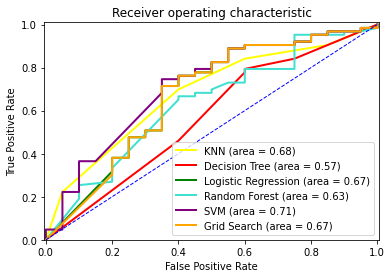

In [76]:
# The following line will tell Jupyter Notebook to keep the figures inside the explorer page 
%matplotlib inline

plt.figure()

plt.plot(fpr_knn, tpr_knn, color='yellow', lw=2, 
         label='KNN (area = %0.2f)' % AUC_knn)

plt.plot(fpr_dt, tpr_dt, color='red', lw=2, 
         label='Decision Tree (area = %0.2f)' % AUC_dt)

plt.plot(fpr_lr, tpr_lr, color='green', lw=2, 
         label='Logistic Regression (area = %0.2f)' % AUC_lr)

plt.plot(fpr_rf, tpr_rf, color='turquoise', lw=2, 
         label='Random Forest (area = %0.2f)' % AUC_rf)

plt.plot(fpr_svm, tpr_svm, color='purple', lw=2, 
         label='SVM (area = %0.2f)' % AUC_svm)

plt.plot(fpr_gs, tpr_gs, color='orange', lw=2, 
         label='Grid Search (area = %0.2f)' % AUC_gs)

# Random Guess line:
plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

# Defining The Range of X-Axis and Y-Axis:
plt.xlim([-0.005, 1.005])
plt.ylim([0.0, 1.01])

# Labels, Title, Legend:
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()